In [1]:
!pip install intersect

  Using cached intersect-1.2-py3-none-any.whl (4.6 kB)
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/opt/conda/lib/python3.9/site-packages/tests/__init__.py'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the '/opt/conda/bin/python3.9 -m pip install --upgrade pip' command.


In [6]:
import sim
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import fsolve

from PythonRobotics.PathPlanning.DubinsPath import dubins_path_planner
from intersect import intersection

import time
import random

In [3]:
class simulation(object):
    def __init__(self, marker = [0,-100] ):
        self.initial_conditions = np.array([0,  #x
                                            0,  #y
                                            0,  #vx
                                            0,  #vy
                                            0,  #phi
                                            0,  #omega
                                            0]) #time
        self.marker = marker
        self.end_yaw = 0
        self.dt = 0.1
        self.state = []
        self.path_x = None
        self.path_y = None
        self.path_yaw = None
        
        sim.initialize_boat(self.initial_conditions, self.marker)          #always begin by initializing the boat
        sim.setVelDir(0, 0)
        self.path_generation()
        
        self.T = 1
    
    
    def path_generation(self):
        '''
        takes the start and end position and generates a dubins path between them
        Requires dubins_path_planner from pythonrobotics
        '''
        endpoint_x = self.marker[0] - 10  # [m]
        endpoint_y = self.marker[1] # [m]
        endpoint_yaw = np.deg2rad(self.end_yaw)  # [rad]
        curvature = .035
        self.path_x, self.path_y, self.path_yaw, mode, _ = dubins_path_planner.plan_dubins_path(
            self.initial_conditions[0], self.initial_conditions[1], self.initial_conditions[4], 
            endpoint_x, endpoint_y, endpoint_yaw, curvature, step_size=.1)
        
        #add extra length to path at very end
        extra_x_length = np.linspace(endpoint_x, self.marker[0] + 50, 100)
        extra_y_length = np.full(100, endpoint_y)
        
        self.path_x = np.append(self.path_x, extra_x_length)
        self.path_y = np.append(self.path_y, extra_y_length)
    
    
    def findIntersection(self, function_1, function_2):
        '''
        inputs two lists - both in form [x,y]
        returns all of the intersections in two arrays: x and y
        '''

        x1 = function_1[0]
        y1 = function_1[1]

        x2 = function_2[0]
        y2 = function_2[1]
        x, y = intersection(x1, y1, x2, y2)

        return x, y


    def find_future_intercept(self, width = 10, foresight = 20 ):
        '''
        This function generates a line in front of the boat orthogonal to the straight line path the boat is currently taking.
        It then finds the intercept of that line and the generated dubins path
        
        Inputs:
        ----------------
        width: int: the length of the orthogonal line
        foresight: int: how far ahead the orthogonal line is generated
        
        returns
        ----------------
        results: 2x1 array, elements are 1xN size arrays
        '''
        x = self.state[-1][0]
        y = self.state[-1][1]
        phi = self.state[-1][4]

        x_forward = x + foresight*np.cos(phi)
        y_forward = y + foresight*np.sin(phi)

        t = np.linspace(-width, width, 100)
        x_vec = -np.sin(phi)*t + x_forward
        y_vec = np.cos(phi)*t + y_forward

        thing1 = [self.path_x, self.path_y]
        thing2 = [x_vec, y_vec]

        results = self.findIntersection(thing1, thing2)
        
        return results
    
        
    def simulate(self):
        '''
        simulates the boat motion with control
        
        '''
        i = 0   
        i_max = 2000
        P = 0
        T = 1
        done = False
        ending = False
        k = 10
        
        while not done:
            self.state.append(sim.step(self.dt, [1 * T, 40 * P]))
            
            x = self.state[-1][0]
            y = self.state[-1][1]
            phi = self.state[-1][4]
            
            results = self.find_future_intercept(width = 30, foresight = 15)
            
            a = 0
            if len(results[0]) > 1:
                distance_from_boat = 10000
                
                for i in range(len(results[0])):
                    distance = (x - results[0][i])**2 + (y - results[1][i])**2
                    a = i if distance < distance_from_boat else a  
                    distance_from_boat = distance

            #print(results, a)
            x_intercept = results[0][a]
            y_intercept = results[1][a]
            
            vector_straight = [20*np.cos(phi), 
                          20*np.sin(phi)]
            
            vector_orthogonal = [x_intercept - (x + vector_straight[0]),
                                 y_intercept - (y + vector_straight[1])]
            
            cross = vector_straight[0] *  vector_orthogonal[1] - vector_straight[1] *  vector_orthogonal[0]
            P = float(-cross/k)
            P = max(min(1, P), -1)
            
            #speed control. This is really basic right now
            dist_to_final = np.sqrt((x - self.marker[0])**2 + (y - self.marker[1])**2)
            
            if dist_to_final < 10 and ending == False:
                i_max = i + 500
                ending = True
                
            if (dist_to_final < 15) and (self.state[-1][2] > 0) and (T > 0):
                T -= 0.015
                
            if ((abs(self.state[-1][2]) + abs(self.state[-1][3])) < .1) and (i > 100):
                done = True
                print('stopped')
        
            '''if i%100 == 0:
                print(x_int, y_int)'''
                
            if i > i_max:
                done = True
                
            i += 1
            
           

stopped


<IPython.core.display.Javascript object>


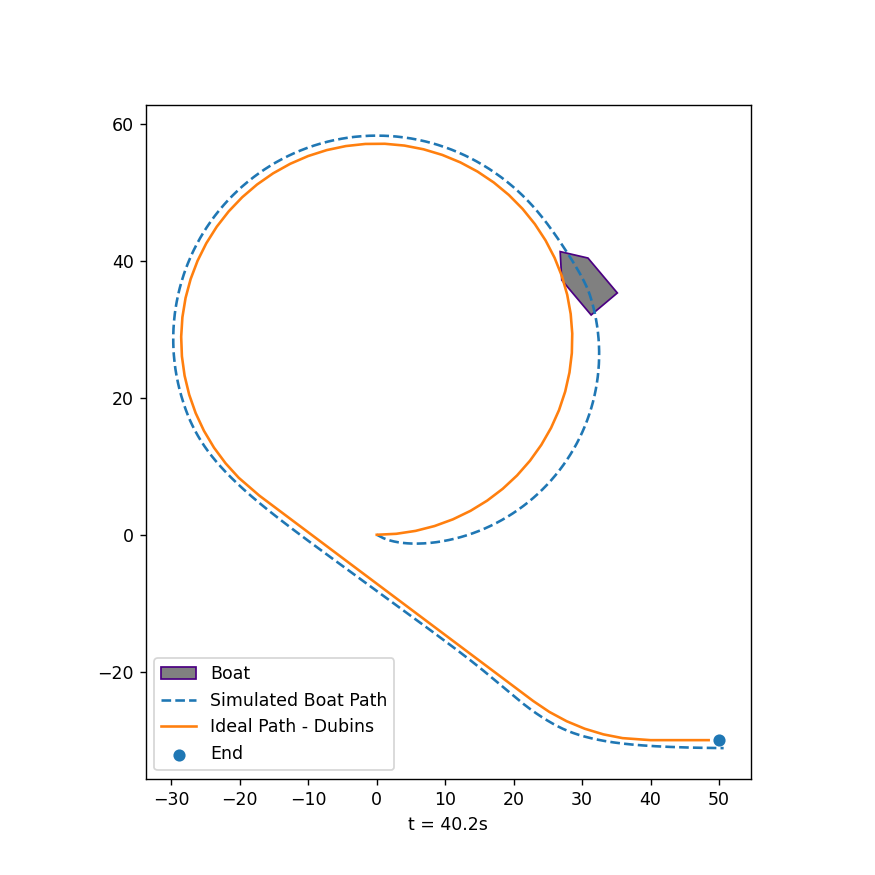

In [4]:
%matplotlib notebook

#initialize the simulation
thing = simulation(marker = [50, -30])

#begin the simulation
thing.simulate()

#animate the simulation
state = np.vstack(thing.state)
sim.animate_boat(state)

#plot the intended and marker position
x, y = thing.path_x[:-85], thing.path_y[:-85]
plt.plot(x, y)
plt.scatter(thing.marker[0], thing.marker[1])
plt.legend(labels = ['Boat', 'Simulated Boat Path', 'Ideal Path - Dubins', 'End'], loc = 'best')